## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import time
import pickle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [42]:
# #This is used for my GPU version.
# with open('train27.p', 'wb') as handle:
#     pickle.dump(train, handle, protocol=2)
    
# with open('test27.p', 'wb') as handle:    
#     pickle.dump(test, handle, protocol=2)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

18


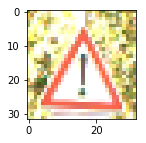

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image)
print(y_train[index])

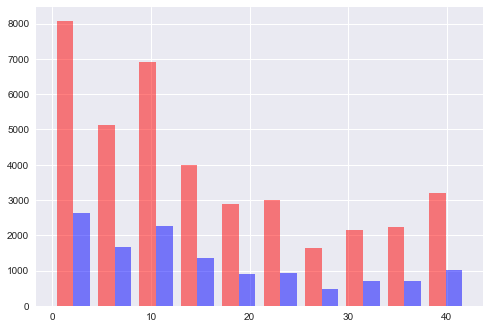

In [4]:
### Check the traffic signs distribution
import seaborn as sns
plt.hist([y_train, y_test], color=['r','b'], alpha=0.5)
plt.show()

From the plot above, we can find that the traffic signs are not evenly distributed.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### 1)  Data preprocessing

In [5]:
### Preprocess the data here.

def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_train = normalize_grayscale(X_train)
X_test = normalize_grayscale(X_test)

In [6]:
print(X_train.shape)

(39209, 32, 32, 3)


In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

#### 2) Train, Test split

In [8]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

n_train_new = int(n_train * 0.8)

X_validation, y_validation = X_train[n_train_new:,], y_train[n_train_new:,]
X_train, y_train = X_train[:n_train_new,], y_train[:n_train_new,]

In [15]:
print(X_train.shape)
print(X_validation.shape)

(31367, 32, 32, 3)
(7842, 32, 32, 3)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In this part, I first normalize the image data and then shuffle the training dataset.
- Normalization: avoid the influence of different scales regarding the feature.
- Shuffle: avoid the influence of the ordering of data.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Testing data are read directly from pickle file. For training and validation, I use 80% for training and 20% for validation.

#### 3) Architecture



##### Basic - Logistic regression

The model below is a simple logistic regression, and the training accuracy is 86.1%. We can use it as a baseline.

In [71]:
def basic(x):
    mu = 0
    sigma = 0.1
    n_input = image_shape[0] * image_shape[1] * image_shape[2]
    flat_x = tf.reshape(x, [-1, n_input])
    W = tf.Variable(tf.truncated_normal(shape=(n_input, n_classes), mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(flat_x, W) + b
    return logits

######################## Training ##########################
EPOCHS = 10
BATCH_SIZE = 128
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

logits = basic(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

import time

start = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    
print(time.time() - start)

Training...

EPOCH 1 ...
Validation Accuracy = 0.594

EPOCH 2 ...
Validation Accuracy = 0.706

EPOCH 3 ...
Validation Accuracy = 0.767

EPOCH 4 ...
Validation Accuracy = 0.791

EPOCH 5 ...
Validation Accuracy = 0.828

EPOCH 6 ...
Validation Accuracy = 0.830

EPOCH 7 ...
Validation Accuracy = 0.865

EPOCH 8 ...
Validation Accuracy = 0.847

EPOCH 9 ...
Validation Accuracy = 0.866

EPOCH 10 ...
Validation Accuracy = 0.890

19.25421404838562


Since convolutional layer is quite effective for image classification, we add one convolutional layer together with a pooling layer to the baseline model. 

##### Add one convolutional layer

In [16]:
def advan1(x):
    mu = 0
    sigma = 0.1
    
    # Convolutional. Input = 32x32x3. Output = 30x30x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling Input = 30x30x6. Output = 15x15x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten
    fc0   = flatten(conv1)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1350, 43), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(43))
    logits   = tf.matmul(fc0, fc1_W) + fc1_b

    return logits
    
######################## Training ##########################
EPOCHS = 10
BATCH_SIZE = 128
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

logits = advan1(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

import time

start = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    
print(time.time() - start)


Training...

EPOCH 1 ...
Validation Accuracy = 0.583

EPOCH 2 ...
Validation Accuracy = 0.789

EPOCH 3 ...
Validation Accuracy = 0.858

EPOCH 4 ...
Validation Accuracy = 0.884

EPOCH 5 ...
Validation Accuracy = 0.917

EPOCH 6 ...
Validation Accuracy = 0.914

EPOCH 7 ...
Validation Accuracy = 0.911

EPOCH 8 ...
Validation Accuracy = 0.932

EPOCH 9 ...
Validation Accuracy = 0.943

EPOCH 10 ...
Validation Accuracy = 0.929

84.63370895385742


Compare advan1(x) architecture and basic(x) architecture we can find that the training accuracy imporves from 0.865 to 0.929, which implies the effectiveness of convolutional layer. 

##### Final architecture 

In [17]:
def advan2(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 30x30x6. Output = 15x15x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout
    conv1_drop = tf.nn.dropout(conv1, keep_prob)

    # Layer 2: Convolutional. Output = 12x12x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1_drop, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 12x12x16. Output = 6x6x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout
    conv2_drop = tf.nn.dropout(conv2, keep_prob)

    # Flatten. Input = 6x6x16. Output = 576.
    fc0   = flatten(conv2_drop)
    
    # Layer 3: Fully Connected. Input = 576. Output = 240.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(576, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 240. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b    
    
    return logits


In [22]:
EPOCHS = 15
BATCH_SIZE = 256
rate = 0.002

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)
saver = tf.train.Saver()

logits = advan2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

import time

start = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    
print(time.time() - start)


Training...

EPOCH 1 ...
Validation Accuracy = 0.738

EPOCH 2 ...
Validation Accuracy = 0.869

EPOCH 3 ...
Validation Accuracy = 0.930

EPOCH 4 ...
Validation Accuracy = 0.952

EPOCH 5 ...
Validation Accuracy = 0.957

EPOCH 6 ...
Validation Accuracy = 0.960

EPOCH 7 ...
Validation Accuracy = 0.968

EPOCH 8 ...
Validation Accuracy = 0.974

EPOCH 9 ...
Validation Accuracy = 0.976

EPOCH 10 ...
Validation Accuracy = 0.967

EPOCH 11 ...
Validation Accuracy = 0.981

EPOCH 12 ...
Validation Accuracy = 0.982

EPOCH 13 ...
Validation Accuracy = 0.979

EPOCH 14 ...
Validation Accuracy = 0.984

EPOCH 15 ...
Validation Accuracy = 0.981

Model saved
229.60011291503906


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The final fine tuned architecture is shown above.

- I use CNN, with 2 convolutional layers, followed by max pooling and dropout, and 3 fully connected layers.
- For the two convolutional layers, one is 3X3 filter and one is 4X4 filter. Both use Relu as activations.
- After the convolutional layer, the network is flattened.
- For the three fully connected layers, all use Relu as activations.

- The reason for max pooling is: to help over-fitting by providing an abstracted form of the representation. As well, it reduces the computational cost by reducing the number of parameters to learn and provides basic translation invariance to the internal representation.
- The reason for dropout layer is: to prevent overfitting.
- The reason of using Relu is: besides adding non-linearity and sparsity, it can also help reduce the likelihood of vanishing gradient.

#### Test 

In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.925


The test accuracy is 0.925, compared to validation accuracy 0.982 indicates the overfitting of the training data.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

- Optimizer: AdamOptimizer
- Batch size: 256
- Epochs: 15
- Learning rate: 0.002

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

- The first step is to build up a simple one layer nerual network and run the model as a baseline.
- The second step I add convolutional layer to the model.
- The third step I keep the general architecture and modify the filter size for each convolutional layer. Since the image size is 32X32, 5X5 filters might be too large. So I choose 3X3 and 4X4 instead. 
- In order to avoid overfitting I then add max pooling layer and dropout layer. First I start with the keep_probability = 0.5, then I slowly increase it. When it is set to 0.75 the validation accuracy is the best.
- Then I increase the batch size to 256 to lower the weight update noise and increase the computation time a bit. Since the time is still within the acceptable range.
- Next I tuned the learning rate and choose 0.002 as the final value.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [24]:
import os
os.listdir("trafficsign_test/")

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']

In [32]:
from scipy.misc import imread, imsave, imresize

image_num = len(os.listdir("trafficsign_test/"))
X_test_real = np.zeros((image_num,32,32,3), dtype = np.uint8)

for i in range(image_num):
    im_name = "trafficsign_test/" + str(i+1) + '.jpg'
    img = imread(im_name)
    img_resize = imresize(img, (32, 32))
    X_test_real[i] = img_resize
    
X_test_real_norm = normalize_grayscale(X_test_real)

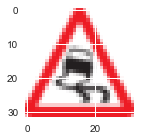

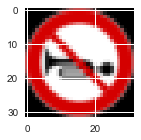

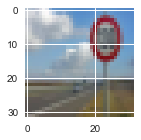

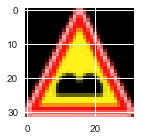

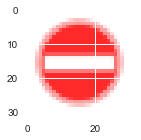

In [34]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
for i in range(image_num):
    image = X_test_real[i].squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(image)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

- The images are shown above.
- The factors that could potentially influence the accuracy might be the background colors.

In [54]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

predict_label = tf.argmax(logits, 1)
predict_top5 = tf.nn.top_k(logits, k=5)
predict_prob = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    labels = sess.run(predict_label, feed_dict={x: X_test_real_norm, keep_prob: 1.0})
    test_predict = sess.run(predict_label, feed_dict={x: X_test, keep_prob: 1.0})
    top5 = sess.run(predict_top5, feed_dict={x: X_test_real_norm, keep_prob: 1.0})
    probs = sess.run(predict_prob, feed_dict={x: X_test_real_norm, keep_prob: 1.0})
    print(labels)

[11 10 12 26 17]


##### Compute confusion matrix for test data

In [57]:
from sklearn.metrics import confusion_matrix

mm = confusion_matrix(y_test, test_predict)
#test image
#1
print(mm[23,:])
#3
print(mm[8,:]) 
#4
print(mm[22,:])
#5
print(mm[17,:])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  15   1   1   0 128   0   0   0   0   1   0   3   1   0   0   0   0
   0   0   0   0   0   0   0]
[  0   1   2   0   2   1   0   2 435   0   0   0   0   2   0   0   0   0
   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   1   0   0   0 106   0   0   5   8   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
[  4   0   0   0   0   0   0   0   0   0   0   0   1   0   1   0   0 350
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0
   0   1   0   0   0   0   0]


In [53]:
#Interpret predictions in terms of sign names

import csv
import pandas as pd

signnames = pd.read_csv('signnames.csv')
signnames.to_dict()
sign_dict = dict(zip(signnames.ClassId, signnames.SignName))

for i in range(image_num):
    print (sign_dict[labels[i]])

Right-of-way at the next intersection
No passing for vehicles over 3.5 metric tons
Priority road
Traffic signals
No entry


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

- The predictons accuracy is 1 out of 5, 20% accurate on captured pictures.
- The prediction accuracy is 92.5% on the test dataset. 20% is greatly lower than 92.5%, so the model might suffer from overfitting. To be more specific: the correct labels for the four images(except 2nd) are slippery road(label 23), speed limit(label 8), bumpy road(label 22), no entry(label 17). The accuracy in the test data seems quite hight(shown in confusion matrix) compared to the external images.
- The second sign doesn't appear in the 43 categories. And the model regards it as No passing.


In [48]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

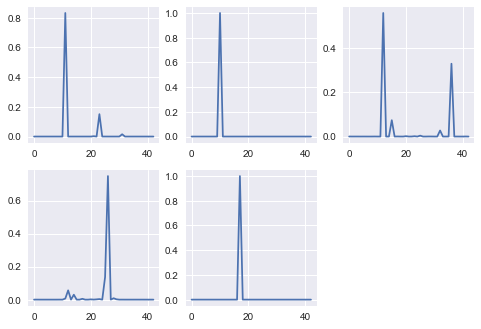

In [46]:
plt.figure(1)
plt.subplot(231)
plt.plot(probs[0])
plt.subplot(232)
plt.plot(probs[1])
plt.subplot(233)
plt.plot(probs[2])
plt.subplot(234)
plt.plot(probs[3])
plt.subplot(235)
plt.plot(probs[4])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

#### The top 5 predictions are:

In [47]:
for i in range(5):
    t = [sign_dict[x] for x in top5[1][i]]
    print(t)
    print('\n')

['Right-of-way at the next intersection', 'Slippery road', 'Wild animals crossing', 'Double curve', 'Road narrows on the right']


['No passing for vehicles over 3.5 metric tons', 'Slippery road', 'No passing', 'Dangerous curve to the left', 'Right-of-way at the next intersection']


['Priority road', 'Go straight or right', 'No vehicles', 'End of all speed and passing limits', 'Road work']


['Traffic signals', 'Road work', 'Priority road', 'Stop', 'Children crossing']


['No entry', 'Stop', 'No passing', 'Bicycles crossing', 'Speed limit (20km/h)']




**Answer:**

- If we look at the top 5 predictions, the prediction of the 1st image, which is slippery road, lies within top 5. 
- The correct sign for the 3rd image, due to the background colors having too much noise, still doesn't appear in top 5.
- The sign for the 2nd image is out of 43 categories. So there is no correct prediction.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.